In [20]:
import sys
sys.path.append("..")
import pandas as pd
import util_functions as uf
import altair as alt
import json
import requests
from datetime import date

In [2]:
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

In [3]:
def lime_totals(con):
    # Query Dockless Start by ANC and Overlaps
    return pd.read_sql("""SELECT DISTINCT
                            total_lime.date,
                            daily_lime_count as total,
                            case when daily_scooter_count is null then daily_lime_count
                            else daily_lime_count - daily_scooter_count end as bikes,					   
                            daily_scooter_count as scooters
                            FROM
                            /* Count of Total Lime Vehicles per Day*/
                            (
                            SELECT
                            created::date as date,
                            count(distinct bike_id) as daily_lime_count
                            from bike_locations
                            where provider='limebike'
                            GROUP BY 1) as total_lime
                            /* Count of Total Lime Scooters per Day*/
                            LEFT JOIN
                            (SELECT
                            locations.date,
                            count(distinct locations.bike_id) as daily_scooter_count
                            FROM (SELECT DISTINCT
                                  created::date as date, bike_id 
                                  from bike_locations
                                  where provider='limebike') as locations
                            JOIN
                            (SELECT DISTINCT bike_id
                                             from bike_locations
                                             where raw->'attributes'->>'vehicle_type'='scooter') as scooters
                                             on locations.bike_id = scooters.bike_id
                            GROUP BY 1
                            ORDER BY 1) as scoots_lime
                            on scoots_lime.date = total_lime.date
;
                """, con=con)

In [4]:
uf.set_env_path()
conn, cur = uf.local_connect()
# Return Dataframe of Percent of Trips by ANC
df = lime_totals(con=conn)


In [5]:
df['date'] = pd.to_datetime(df['date'])

In [62]:
melted_df =  pd.melt(df, id_vars=['date'],
                         value_vars=['bikes', 'scooters'],
                         var_name = 'Lime Vehicles'
                         )
melted_df=melted_df.rename(columns = {'value':'Daily Vehicles on Street'})

## Add Timeline Events to Dataframe to Annotate Plot

* 3/10/2018 - Scooters Introducted
* 5/21/2018 - Shift to more scooters announced

In [70]:
dates = [date(2018,3,10), date(2018,5,21)]
events = ['Scooters Intro  ', 'More scooters announced  ']
timeline_df = pd.DataFrame({'date': dates, 'event': events})
timeline_df['Lime Vehicles'] = 'scooters'
timeline_df['date'] = pd.to_datetime(timeline_df['date'])


merge_df = melted_df.merge(timeline_df, on=['date', 'Lime Vehicles'], how='left')
merge_df['event'] =  merge_df['event'].fillna('')

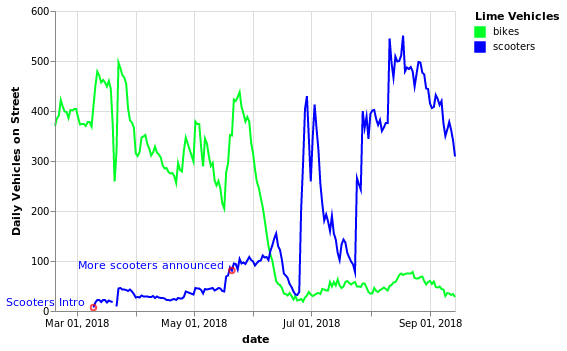

In [71]:
line_chart = alt.Chart(merge_df).mark_line().encode(
             alt.X('date'),
             alt.Y('Daily Vehicles on Street'),
             alt.Color('Lime Vehicles',
                      scale=alt.Scale(range=['#00ff26', 'blue']))
             )


# points
points = alt.Chart(merge_df[merge_df['event'] != '']
             ).mark_point(color='red'
                
             ).encode(
             alt.X('date'),
             alt.Y('Daily Vehicles on Street')
)

# Annotated points
text = line_chart.mark_text(
                  align='right',
                  baseline='bottom',
                    
        ).encode(
            text='event'
        )


line_chart + points + text

## Plot Analysis

Scooters are introduced on March 10, 2008 and their numbers on the street remain fairly flat until late May, when Lime announced that would start placing more scooters and removing a proportionate number of bikes to adhere to the DDOT dockless pilot 400 vehicle cap.  

At about the same time, the average number of Lime bikes on the street reach their max for this time period at slightly more than 400 and takes a nose dive through the month of June.  At this point it looks like Lime made the decision to comprise their fleet of almost all scooters, which has persisted until today.

Overall, we can see large swings in the number of vehicles on the street, as Lime is constantly replacing scooters and bikes.  This can most easily be seen in mid-July where right, only three weeks after putting 400+ scooters on the street, there are less than 200 scooters on the street, while the number of bikes stays relatively consistent.  

It's possible that the popularity of the scooters caused wear and tear at a rate higher than Lime could replace them with new scooters.  We see an overcompensation for this phenomon in late August and early September where an average of over 500 scooters are on the street and then steadily declines over the following weeks.

Between March 10th and mid September, Lime used at least 1,886 scooters and 3,960 total vehicles.  We don't know the exact numbers scooters used during this time period because Lime did not differentiate between scooters and bikes until June 13th, and we had to reverse engineer the scooter count prior to that date.  If a scooter was put on the street and subsequently removed prior to June 13th, we cannot identify that vehicle as a scooter, resulting in our scooter estimate being low.

### Notes to Integrate into analysis

* On date that more scooters announced, number of bikes begins to increase rapidly
* Download trend for Jump looks similar to Lime after going vast majority scooters


In [47]:
# Total Scooters

total_scooters= pd.read_sql("""SELECT DISTINCT count(distinct bike_id)
                               from bike_locations
                               where raw->'attributes'->>'vehicle_type'='scooter';
                """, con=conn)

total_scooters

,count
0,1886


In [48]:
# Total Limes
total_limes= pd.read_sql("""SELECT DISTINCT count(distinct bike_id)
                               from bike_locations
                               where provider = 'limebike'
                               ;
                """, con=conn)

total_limes


,count
0,3960


In [52]:
# Average Age of Scooters
scooter_age = pd.read_sql("""select
                            AVG(bike_age) as avg_bike_age
                            FROM
                            /*determine scooter age*/
                            (SELECT
                            locations.bike_id,
                            min(created) as start_date,
                            MAX(created) - MIN(created) as bike_age
                            FROM 
                            /*determine lime scooters*/ 
                            (SELECT DISTINCT
                              created, bike_id 
                              from bike_locations
                              where provider='limebike') as locations
                            JOIN
                            (SELECT DISTINCT bike_id
                                     from bike_locations
                                     where raw->'attributes'->>'vehicle_type'='scooter') as scooters
                            on locations.bike_id = scooters.bike_id
                            GROUP BY 1) as bike_age
                            where start_date <= '2018-08-18' """, con=conn)
scooter_age

,avg_bike_age
0,22 days 21:01:29.382262


## Vehicle Count Analysis

Between March 10th and mid September, Lime used at least 1,886 scooters and 3,960 total vehicles.  We don't know the exact numbers scooters used during this time because Lime did not differentiate between scooters and bikes until June 13th, and we had to reverse engineer the scooter count prior to that date.  If a scooter was put on the street and subsequently removed prior to June 13th, we cannot identify that vehicle as a scooter, resulting in our scooter estimate being low.

The average duration that scooters are on the streets for those scooters that were places on the street on or before August 18th is slightly under 23 days, well below the average of 70 days that dockless bikes lasted on the street between September and April as cited in my prior post, again pointing toward more wear and tear due to popularity
